### Library Imports

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import re
tqdm.pandas() 
from sklearn.metrics import classification_report,confusion_matrix

### Downloading the Dataset and performing Preprocessing

In [2]:
dataset = load_dataset("stanfordnlp/imdb")

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

In [3]:
def clean_text(text):
    text = text.lower()                                                             # Convert to lowercase
    text = re.sub(r'http\S+', '', text)                                             # Remove URLs
    text = re.sub(r'<.*?>', '', text)                                               # Remove HTML tags
    text = re.sub(r'\[.*?gif.*?\]', '', text, flags=re.IGNORECASE)                  # Remove gifs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)                                        # Remove special characters
    return text

In [4]:
df_train['cleaned_text'] = df_train['text'].progress_apply(clean_text)  

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:02<00:00, 10464.03it/s]


In [5]:
df_test['cleaned_text'] = df_test['text'].progress_apply(clean_text)

100%|██████████| 25000/25000 [00:02<00:00, 10707.78it/s]


##  Bert Model

### Tokenization and Encoding

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(df_train['cleaned_text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(df_test['cleaned_text'].tolist(), truncation=True, padding=True, max_length=512)

### Creating train-test Dataset and DataLoader

In [7]:
# Convert the labels to tensor
train_labels = torch.tensor(df_train['label'].tolist())
test_labels = torch.tensor(df_test['label'].tolist())

# Create TensorDataset
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                               torch.tensor(train_encodings['attention_mask']),
                               train_labels)

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                              torch.tensor(test_encodings['attention_mask']),
                              test_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Training Bert Model

In [8]:
# Load the pre-trained BERT model for classification
torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Setup the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model (simplified version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1}/{epochs} completed with loss: {epoch_loss/len(train_dataloader)}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 782/782 [26:51<00:00,  2.06s/it]


Epoch 1/5 completed with loss: 0.25432017085897496


100%|██████████| 782/782 [27:16<00:00,  2.09s/it]


Epoch 2/5 completed with loss: 0.15366034750062066


100%|██████████| 782/782 [25:20<00:00,  1.94s/it]


Epoch 3/5 completed with loss: 0.09668164846875593


100%|██████████| 782/782 [24:47<00:00,  1.90s/it]


Epoch 4/5 completed with loss: 0.06162498062154959


100%|██████████| 782/782 [24:35<00:00,  1.89s/it]

Epoch 5/5 completed with loss: 0.04062457581582453


### Evaluation of the Model

100%|██████████| 782/782 [09:42<00:00,  1.34it/s]


              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93     12500
    Positive       0.94      0.92      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



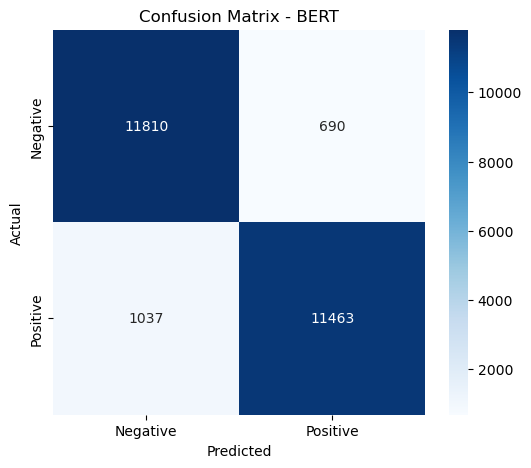

In [9]:

model.eval()
y_pt = []
y_gt = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        y_pt.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        y_gt.extend(labels.cpu().numpy())

print(classification_report(y_gt, y_pt, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_gt, y_pt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT')
plt.show()